MFCC를 이용한 화자 검증 실습

In [ ]:
#@title 1. 의존성 설치 & FSDD 클론
!pip install librosa scikit-learn joblib ipywidgets soundfile tqdm koreanize-matplotlib
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00
Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 29.00 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
#@title 2. 공통 함수 정의 (녹음 / MFCC 추출)
import io, time
from base64 import b64decode
from IPython.display import Javascript, display, Audio, Markdown
from google.colab import output
import numpy as np
import librosa
import koreanize_matplotlib  # 한글 폰트 적용
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ipywidgets as widgets

# 녹음용 전역변수 및 콜백 등록
audio_data = None
def _receive_audio(b64):
    global audio_data
    audio_data = b64decode(b64)
output.register_callback('notebook.receive_audio', _receive_audio)

def record_audio(duration=3):
    """
    Colab 브라우저에서 duration초 녹음 → numpy array 반환
    """
    global audio_data
    audio_data = None
    display(Javascript(f"""
    async function record(sec) {{
      const stream = await navigator.mediaDevices.getUserMedia({{audio:true}});
      const mediaRecorder = new MediaRecorder(stream);
      let chunks = [];
      mediaRecorder.ondataavailable = e => chunks.push(e.data);
      mediaRecorder.start();
      setTimeout(() => mediaRecorder.stop(), sec*1000);
      mediaRecorder.onstop = async () => {{
        const blob = new Blob(chunks, {{type:'audio/wav'}});
        const reader = new FileReader();
        reader.readAsDataURL(blob);
        reader.onloadend = () => {{
          const base64 = reader.result.split(',')[1];
          google.colab.kernel.invokeFunction('notebook.receive_audio', [base64], {{}});
        }};
      }};
    }}
    record({duration});
    """))
    while audio_data is None:
        time.sleep(0.1)
    wav_bytes = io.BytesIO(audio_data)
    audio, sr = librosa.load(wav_bytes, sr=16000)
    return audio

def extract_mfcc(audio, sr=16000, n_mfcc=20):
    """
    MFCC를 뽑아 각 계수의 평균·표준편차를 합쳐 반환
    """
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.concatenate([mfcc.mean(axis=1), mfcc.std(axis=1)])

In [ ]:
#@title 3. FSDD 데이터로 화자 모델 학습
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# FSDD 경로 설정
fsdd_path = 'free-spoken-digit-dataset/recordings'
files = [f for f in os.listdir(fsdd_path) if f.endswith('.wav')]

# 특징·레이블 추출
X, y = [], []
for fn in tqdm(files, desc='FSDD 처리'):
    speaker = fn.split('_')[1]
    audio, _ = librosa.load(os.path.join(fsdd_path, fn), sr=16000)
    feat = extract_mfcc(audio, n_mfcc=20)
    X.append(feat); y.append(speaker)

X = np.vstack(X); y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SVM 학습 및 평가
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True))
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print('테스트 정확도:', accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

FSDD 처리:   0%|          | 0/3030 [00:00<?, ?it/s]

테스트 정확도: 0.9983498349834984
              precision    recall  f1-score   support

      george       1.00      1.00      1.00       100
     jackson       1.00      1.00      1.00       100
           k       1.00      1.00      1.00         2
          kh       1.00      0.50      0.67         2
         khg       0.67      1.00      0.80         2
       lucas       1.00      1.00      1.00       100
     nicolas       1.00      1.00      1.00       100
        theo       1.00      1.00      1.00       100
    yweweler       1.00      1.00      1.00       100

    accuracy                           1.00       606
   macro avg       0.96      0.94      0.94       606
weighted avg       1.00      1.00      1.00       606



본인의 화자 이름을 입력하세요: l


**선택 파일:** `/content/free-spoken-digit-dataset/recordings/1_nicolas_1.wav`

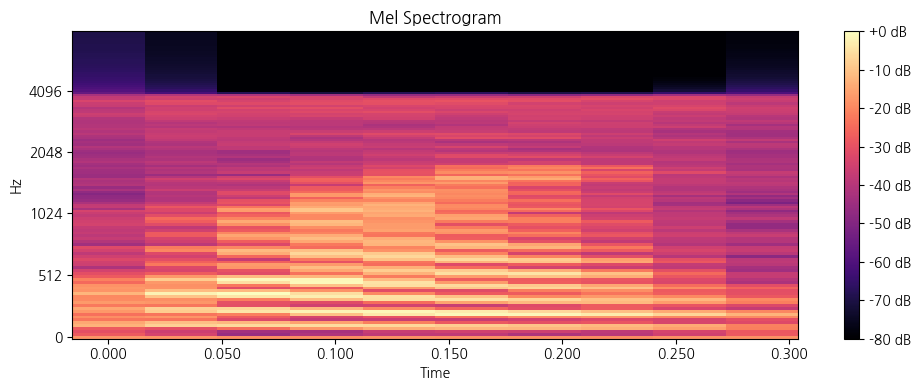


예측 화자: nicolas (확률 1.00)
인증 실패 


In [ ]:
#@title 4. 화자 인증
import os
import librosa, librosa.display
from IPython.display import Audio, Markdown
import matplotlib.pyplot as plt
import numpy as np

# 1) 주장 화자 입력
claimed = input("본인의 화자 이름을 입력하세요: ") # 밑의 절대 경로에서의 화자 이름과 일치해야지만 인증이 성공된다.

# 2) 절대 경로를 직접 하드코딩
filepath = '/content/free-spoken-digit-dataset/recordings/1_nicolas_1.wav'  # 여기에 인증할 WAV 파일의 절대 경로를 적어주세요

if not os.path.isfile(filepath):
    raise FileNotFoundError(f"경로에 파일이 없습니다: {filepath}")

# 3) 오디오 로드 및 재생
audio_auth, sr = librosa.load(filepath, sr=16000)
display(Markdown(f"**선택 파일:** `{filepath}`"))
display(Audio(audio_auth, rate=sr, autoplay=False))

# 4) Mel Spectrogram 계산 및 시각화
S = librosa.feature.melspectrogram(y=audio_auth, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

# 5) MFCC 추출 및 예측
feat_auth = extract_mfcc(audio_auth, sr=sr).reshape(1, -1)
pred = clf.predict(feat_auth)[0]
prob = clf.predict_proba(feat_auth).max()

# 6) 결과 출력
print(f"\n예측 화자: {pred} (확률 {prob:.2f})")
print("인증 성공 " if pred == claimed else "인증 실패 ")

### **연습문제**

**이전 수업에서 사용한 음성녹음 코드를 이용해** 아래 요구사항을 따라 화자 데이터셋을 구성하고 위 코드를 적용하여 화자인증 시스템을 구축하세요.

1. 3명 이상의 서로 다른 화자를 선정한다.
2. 각 화자당 10개 이상의 음성 샘플을 녹음하되, 녹음 길이는 3초로 고정한다.
3. 프로젝트 루트에 `recordings/` 디렉토리를 생성하고, 파일명을 다음 규칙으로 저장한다.
{speaker}_{index}.wav

녹음한 음성파일을 free-spoken-digit-dataset으로 옮겨야 된다. 왜냐 위에서 이 폴더 내 recordings폴더에서 학습을 진행하기 때문이다.

In [ ]:
!pip install -q librosa soundfile

import warnings
warnings.filterwarnings("ignore")

import os
import time
import csv
import librosa
import soundfile as sf
from base64 import b64decode
from google.colab.output import eval_js
from IPython.display import display, HTML, Audio

# ─── 1. Tacotron 학습용 대본 리스트 ────────────────────────────────────────────
scripts = [
    "오늘",
    "어제",
    "내일",
    "다음 주",
    "한국",
    "중요한",
    "아침",
    "자동차",
    "언어",
    "바닷가"
]

# ─── 2. 녹음 파일 저장 디렉터리 및 메타 리스트 ───────────────────────────────
os.makedirs("recordings", exist_ok=True)
metadata = []  # (wav_path, transcript) 튜플을 저장할 리스트

# ─── 3. 녹음 및 WAV 변환 함수 ─────────────────────────────────────────────────
def record_script(text, filename, duration=7):
    # 화면에 대본 표시
    display(HTML(f"<h3>다음 문장을 따라 읽어주세요:</h3>"
                 f"<p style='font-size:20px;'>{text}</p>"))

    # JS로 녹음 및 카운트다운 UI 실행 (async IIFE로 감싸기)
    js = f"""
(async () => {{
  const duration = {duration};
  const timerDiv = document.createElement('div');
  timerDiv.id = 'countdown';
  timerDiv.style.fontSize = '20px';
  timerDiv.style.marginBottom = '10px';
  document.body.appendChild(timerDiv);

  const stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
  const recorder = new MediaRecorder(stream);
  const chunks = [];
  recorder.ondataavailable = e => chunks.push(e.data);
  recorder.start();

  for (let i = duration; i >= 0; i--) {{
    timerDiv.innerText = `녹음 중: ${{i}}초 남음`;
    await new Promise(r => setTimeout(r, 1000));
  }}

  recorder.stop();
  await new Promise(r => recorder.onstop = r);
  timerDiv.innerText = '녹음 완료!';

  const blob = new Blob(chunks);
  const reader = new FileReader();
  reader.readAsDataURL(blob);
  await new Promise(r => reader.onloadend = r);
  timerDiv.remove();
  return reader.result.split(',')[1];
}})();
    """
    b64data = eval_js(js)
    audio_bytes = b64decode(b64data)

    # WEBM 파일로 임시 저장
    path_webm = os.path.join("recordings", filename + ".webm")
    with open(path_webm, "wb") as f:
        f.write(audio_bytes)

    # librosa로 로드 후 soundfile로 WAV 저장 (16-bit PCM)
    audio, sr = librosa.load(path_webm, sr=441000) #sampling rate 44.1kHz으로 설정
    path_wav = os.path.join("recordings", filename + ".wav")
    sf.write(path_wav, audio, sr, subtype='PCM_16')

    # 임시 WEBM 파일 삭제
    os.remove(path_webm)

    print(f"저장 완료 (WAV): {path_wav}")
    # 녹음된 WAV 재생
    display(Audio(path_wav, autoplay=False))
    return path_wav

# ─── 4. 대본별 순차 녹음 진행 ──────────────────────────────────────────────────
for idx, text in enumerate(scripts, start=1):
    fname = f"0_k_{idx:02d}"
    wav_path = record_script(text, fname, duration=3)
    metadata.append((wav_path, text))
    time.sleep(1)

# ─── 5. CSV로 대본 메타데이터 저장 ─────────────────────────────────────────────
csv_path = os.path.join("recordings", "transcripts.csv")
with open(csv_path, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "transcript"])
    for wav_path, transcript in metadata:
        writer.writerow([os.path.basename(wav_path), transcript])

print(f"\n모든 녹음 완료! 대본 CSV 저장: {csv_path}")

본인의 화자 이름을 입력하세요: khg


**선택 파일:** `/content/free-spoken-digit-dataset/recordings/0_khg_01.wav`

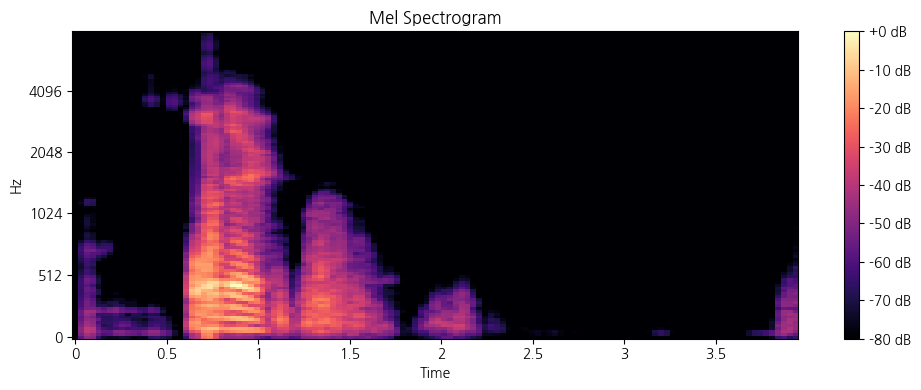


예측 화자: khg (확률 0.34)
인증 성공 


In [ ]:
#@title 4. 화자 인증
import os
import librosa, librosa.display
from IPython.display import Audio, Markdown
import matplotlib.pyplot as plt
import numpy as np

# 1) 주장 화자 입력
claimed = input("본인의 화자 이름을 입력하세요: ") # 밑의 절대 경로에서의 화자 이름과 일치해야지만 인증이 성공된다.

# 2) 절대 경로를 직접 하드코딩
filepath = '/content/free-spoken-digit-dataset/recordings/0_khg_01.wav'  # 여기에 인증할 WAV 파일의 절대 경로를 적어주세요

if not os.path.isfile(filepath):
    raise FileNotFoundError(f"경로에 파일이 없습니다: {filepath}")

# 3) 오디오 로드 및 재생
audio_auth, sr = librosa.load(filepath, sr=16000)
display(Markdown(f"**선택 파일:** `{filepath}`"))
display(Audio(audio_auth, rate=sr, autoplay=False))

# 4) Mel Spectrogram 계산 및 시각화
S = librosa.feature.melspectrogram(y=audio_auth, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

# 5) MFCC 추출 및 예측
feat_auth = extract_mfcc(audio_auth, sr=sr).reshape(1, -1)
pred = clf.predict(feat_auth)[0]
prob = clf.predict_proba(feat_auth).max()
#이때 확률은 음성파일과 입력한 본인이름이 얼만큼 유사한 지를 나타내는 것인가요? -> 맞다.
# 6) 결과 출력
print(f"\n예측 화자: {pred} (확률 {prob:.2f})")
print("인증 성공 " if pred == claimed else "인증 실패 ")

5. Naver clova 서비스와 같은 화자분리(Speaker Diarization)기능을 가진 딕테이션

In [ ]:
!unzip -o recordings_any.zip -d /content

Archive:  recordings.zip
   creating: /content/recordings/
  inflating: /content/recordings/utt_이랑교.wav  
  inflating: /content/__MACOSX/recordings/._utt_이랑교.wav  
  inflating: /content/recordings/utt_백현일.wav  
  inflating: /content/__MACOSX/recordings/._utt_백현일.wav  
  inflating: /content/recordings/utt_조민주.wav  
  inflating: /content/__MACOSX/recordings/._utt_조민주.wav  
  inflating: /content/recordings/utt_강사.wav  
  inflating: /content/__MACOSX/recordings/._utt_강사.wav  
  inflating: /content/recordings/utt_김희건.wav  
  inflating: /content/__MACOSX/recordings/._utt_김희건.wav  


In [ ]:
# 0) 라이브러리 설치 (최초 1회)
!pip install -q transformers librosa pandas scikit-learn joblib

# 1) 모듈 임포트 및 장치 설정
import os
import torch
import librosa
import numpy as np
import pandas as pd
from joblib import load
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from transformers import WhisperProcessor, WhisperForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"

# 2) MFCC 추출 함수
def extract_mfcc(audio, sr=16000, n_mfcc=20):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.concatenate([mfcc.mean(axis=1), mfcc.std(axis=1)])

# 3) 녹음 파일을 이용해 SVM 화자 모델 학습
fsdd_dir = "recordings"  # 음원이 있는 폴더
files = [f for f in os.listdir(fsdd_dir) if f.endswith(".wav")]

X, y = [], []
for fn in files:
    speaker = fn.split("_")[1]  # digit_speaker_index.wav
    audio, _ = librosa.load(os.path.join(fsdd_dir, fn), sr=16000)
    X.append(extract_mfcc(audio, sr=16000))
    y.append(speaker)

X = np.vstack(X)
y = np.array(y)

clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", probability=True)
)
clf.fit(X, y)

# 4) Whisper 프로세서 & 모델 로드 (언어·태스크 지정)
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small",
    language="korean",
    task="transcribe"
)
model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-small"
).to(device)
model.config.pad_token_id = model.config.eos_token_id

# 5) STT 함수 (input_features 패딩/트렁케이트 및 attention_mask 생성)
def transcribe(path):
    audio, sr = librosa.load(path, sr=16000)
    inputs = processor(
        audio,
        sampling_rate=sr,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    # 특징 추출: (batch, n_mels, seq_len)
    features = inputs.input_features
    batch, n_mels, seq_len = features.shape

    # Whisper 내부 conv stride 값 가져오기
    s1 = model.model.encoder.conv1.stride[0]
    s2 = model.model.encoder.conv2.stride[0]
    max_pos = model.config.max_source_positions
    required_len = max_pos * s1 * s2  # 750*2*2 = 3000

    # 패딩 또는 트렁케이트
    if seq_len < required_len:
        pad_amt = required_len - seq_len
        features = torch.nn.functional.pad(features, (0, pad_amt), value=0)
        attention_mask = torch.cat([
            torch.ones((batch, seq_len), device=device),
            torch.zeros((batch, pad_amt), device=device)
        ], dim=1).long()
    else:
        features = features[:, :, :required_len]
        attention_mask = torch.ones((batch, required_len), device=device).long()

    # 생성
    with torch.no_grad():
        generated_ids = model.generate(
            input_features=features,
            attention_mask=attention_mask,
            pad_token_id=model.config.pad_token_id
        )

    # 디코딩
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# 6) 화자 예측 함수
def predict_speaker(path):
    audio, _ = librosa.load(path, sr=16000)
    feat = extract_mfcc(audio, sr=16000).reshape(1, -1)
    pred = clf.predict(feat)[0]
    prob = clf.predict_proba(feat).max()
    return pred, prob

# 7) recordings 폴더 순회하며 STT + 화자인증 결과 수집
records = []
for fn in sorted(files):
    fp = os.path.join(fsdd_dir, fn)
    transcript = transcribe(fp)
    speaker, confidence = predict_speaker(fp)
    speaker = speaker.replace('.wav', '')
    records.append({
        "file": fn,
        "transcript": transcript,
        "speaker": speaker,
        "confidence": round(confidence, 2)
    })

# 8) 결과를 DataFrame으로 정리·표시
df = pd.DataFrame(records)
display(df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


,file,transcript,speaker,confidence
0,utt_강사.wav,안녕하세요. 오늘 날씨는 맑고 화창합니다.,강사,0.23
1,utt_김희건.wav,안녕하세요 오늘 날씨는 맑고 화창합니다,김희건,0.22
2,utt_백현일.wav,안녕하세요 오늘 날씨는 맑고 화창합니다,백현일,0.23
3,utt_이랑교.wav,안녕하세요. 오늘 날씨는 맑고 화창합니다.,이랑교,0.22
4,utt_조민주.wav,안녕하세요 오늘 날씨는 맑고 화창합니다,조민주,0.23


In [ ]:
#문제 2. 두명의 대화를 녹음해 화자분리와 딕테이션으로 대화를 구성해 보세요.
#바로 위에 있는 코드를 사용하여 두 개의 음성파일의 화자를 분리하고, 각 음성파일의 SST를 출력
import random as rd
records = []
for i in range(2):
    fn=files[rd.randrange(0,5)]
    fp = os.path.join(fsdd_dir, fn)
    transcript = transcribe(fp)
    speaker, confidence = predict_speaker(fp)
    speaker = speaker.replace('.wav', '')
    records.append({
        "file": fn,
        "transcript": transcript,
        "speaker": speaker,
        "confidence": round(confidence, 2)
    })

# 8) 결과를 DataFrame으로 정리·표시
df = pd.DataFrame(records)
display(df)

,file,transcript,speaker,confidence
0,utt_강사.wav,안녕하세요. 오늘 날씨는 맑고 화창합니다.,강사,0.23
1,utt_김희건.wav,안녕하세요 오늘 날씨는 맑고 화창합니다,김희건,0.22
